In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Training
num_generations = 3
gamma = 0.999
deterministic=False # BC pretrain
performance_eval = 5
num_perturbations = 64

### Prey ###
lr_prey_policy = 2e-4
sigma_prey = 0.1

prey_dis_balance_factor = 2
prey_noise = 0.005
lr_prey_disc = 5e-4
lambda_gp_prey = 5
prey_update_mode = {"mode": "avoid", "lambda": 0.2}


### Predator ###
lr_pred_policy = 1e-4
sigma_pred = 0.08

pred_dis_balance_factor = 2
pred_noise = 0.005
lr_pred_disc = 2e-4
lambda_gp_pred = 10
pred_update_mode = {"mode": "avoid", "lambda": 0.1}


# Env Settings
height = 2160
width = 2160
prey_speed = 10
pred_speed = 10
step_size = 1.0
max_turn = 0.314 #99-Quantil of Prey Actions

pert_steps = 100
init_steps = 500

env_settings = (height, width, prey_speed, pred_speed, step_size, max_turn, pert_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32)

exp_pred_tensor = exp_pred_tensor.to(device)
exp_prey_tensor = exp_prey_tensor.to(device)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)


init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


In [4]:
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_state = torch.load(r"..\models\trained_policies\Encoder\prey_encoder.pt", map_location=device)
prey_encoder.load_state_dict(prey_state)

for p in prey_encoder.parameters():
    p.requires_grad = False 

prey_encoder.eval()
print("Prey Encoder loaded & frozen.\n")


pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_state = torch.load(r"..\models\trained_policies\Encoder\pred_encoder.pt", map_location=device)
pred_encoder.load_state_dict(pred_state)

for p in pred_encoder.parameters():
    p.requires_grad = False

pred_encoder.eval()
print("Predator Encoder loaded & frozen.")

Prey Encoder loaded & frozen.

Predator Encoder loaded & frozen.


In [5]:
prey_policy = ModularPolicy(features=5).to(device)
prey_policy.load_state_dict(torch.load(r"..\models\trained_policies\BC-Policy\bc_prey_policy.pt", map_location=device))
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Pretrained Prey Policy loaded.\n")

pred_policy = ModularPolicy(features=4).to(device)
pred_policy.load_state_dict(torch.load(r"..\models\trained_policies\BC-Policy\bc_pred_policy.pt", map_location=device))
ema_pred = EMA(pred_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Pretrained Predator Policy loaded.\n")

Pretrained Prey Policy loaded.

Pretrained Predator Policy loaded.



In [6]:
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_prey_disc, alpha=0.99, eps=1e-08)


pred_mmd_loss = MMDLoss(encoder=pred_encoder, role="predator").to(device)
pred_discriminator = Discriminator(encoder=pred_encoder, role="predator", z_dim=32).to(device)
pred_discriminator.set_parameters(init=True)
optim_disc_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_pred_disc, alpha=0.99, eps=1e-08)

sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")

In [7]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to("cuda")
    rollout_pred_policy = ema_pred.ema_model.to("cuda")
    
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=rollout_prey_policy, 
                                                          pred_policy=rollout_pred_policy, 
                                                          n_prey=32, n_pred=1, max_steps=100,
                                                          init_pool=init_pool)


    for i in range(pred_dis_balance_factor):
        # Predator Discriminator Update (larger batch size for imbalance)
        expert_pred_batch = sample_data(exp_pred_tensor, batch_size=20).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, batch_size=20).to(device)

        dis_metric_pred = pred_discriminator.update(expert_pred_batch, generative_pred_batch, optim_disc_pred, 
                                                    lambda_gp_pred, noise=pred_noise, generation=gen, num_generations=num_generations)


    for i in range(prey_dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp_prey, noise=prey_noise, generation=gen, num_generations=num_generations)

        disc_metrics_list.append((dis_metric_prey, dis_metric_pred))                                            
    
        
    # Predator Policy Update
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    pin_pred_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="pairwise", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    an_pred_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="attention", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_pred.update()

    # Prey Policy Update
    pin_prey_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="pairwise", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    an_prey_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="attention", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_prey.update()

    policy_metrics_list.append({"predator": (pin_pred_metrics, an_pred_metrics), "prey": (pin_prey_metrics, an_prey_metrics)})
    
    lr_pred_policy *= gamma
    lr_prey_policy *= gamma
    sigma_pred *= gamma
    sigma_prey *= gamma

    current_prey_state = ema_prey.ema_model.state_dict()
    current_pred_state = ema_pred.ema_model.state_dict()

    if gen % performance_eval == 0:
        metrics = calculate_metrics(pred_policy=pred_policy, prey_policy=prey_policy, 
                                    prey_encoder=prey_encoder, pred_encoder=pred_encoder,
                                    exp_prey_tensor=exp_prey_tensor, exp_pred_tensor=exp_pred_tensor,
                                    prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, sinkhorn_loss=sinkhorn_loss,
                                    init_pool=init_pool, env_settings=env_settings, device="cuda")
        metrics_list.append(metrics)

        best_prey = metrics["mmd_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

        best_pred = metrics["mmd_pred_mean"]
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}
        
    if metrics["mmd_prey_mean"] < best_prey:
        best_prey = metrics["mmd_prey_mean"]
        print(f"New best Prey MMD: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

    if metrics["mmd_pred_mean"] < best_pred:
        best_pred = metrics["mmd_pred_mean"]
        print(f"New best Predator MMD: {best_pred.item()}\n")
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}

    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.4f} ± {metrics['sinkhorn_prey_std']:.4f}")
    print("--------------------------------")
    print(f"[PRED] PIN Network:   {pin_pred_metrics}")
    print(f"[PRED] AN Network:    {an_pred_metrics}")
    print(f"[PRED] Discriminator: {dis_metric_pred}")
    print(f"[PRED] Score Diff: {abs(dis_metric_pred['expert_score_mean'] - dis_metric_pred['policy_score_mean'])}")
    print(f"[PRED] MMD: {metrics['mmd_pred_mean']:.4f} ± {metrics['mmd_pred_std']:.4f} | Sinkhorn: {metrics['sinkhorn_pred_mean']:.4f} ± {metrics['sinkhorn_pred_std']:.4f}\n")


prey_policy.load_state_dict(best_prey_policy_state, strict=True)
pred_policy.load_state_dict(best_pred_policy_state, strict=True)

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Generation 1
[PREY] PIN Network:   {'diff_mean': 0.000572, 'diff_std': 0.015234, 'delta_norm': 0.131127, 'clip_ratio': 1.0, 'delta_raw_norm': 0.131127, 'max_delta_norm': 0.286508, 'avoid/attack reward': 0.123247}
[PREY] AN Network:    {'diff_mean': 0.00089, 'diff_std': 0.012364, 'delta_norm': 0.128696, 'clip_ratio': 1.0, 'delta_raw_norm': 0.128696, 'max_delta_norm': 0.322723, 'avoid/attack reward': 0.144647}
[PREY] Discriminator: {'dis_loss': 0.0003, 'dis_loss_gp': 4.8958, 'grad_penalty': 0.9791, 'expert_score_mean': -0.1147, 'policy_score_mean': -0.1144}
[PREY] Score Diff: 0.0002999999999999947
[PREY] MMD: 1.6264 ± 0.1923 | Sinkhorn: 0.0006 ± 0.0000
--------------------------------
[PRED] PIN Network:   {'diff_mean': 0.001192, 'diff_std': 0.010331, 'delta_norm': 0.102378, 'clip_ratio': 1.0, 'delta_raw_norm': 0.102378, 'max_delta_norm': 0.17918, 'avoid/attack reward': 0.830504}
[PRED] AN Network:    {'diff_mean': 0.000158, 'diff_std': 0.009017, 'delta_norm': 0.100868, 'clip_ratio': 1.0

<All keys matched successfully>

In [8]:
base_dir = Path(r"..\data\2. Training\training\VideoPredPrey - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

prey_path = run_dir / "prey_policy.pth"
torch.save(prey_policy.state_dict(), prey_path)

pred_path = run_dir / "pred_policy.pth"
torch.save(pred_policy.state_dict(), pred_path)

In [ ]:
mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_pred_tensor=exp_pred_tensor, exp_prey_tensor=exp_prey_tensor, 
                                                                        prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, 
                                                                        prey_encoder=prey_encoder, pred_encoder=pred_encoder, 
                                                                        sinkhorn_loss=sinkhorn_loss)

 48%|████▊     | 242/500 [00:13<00:14, 17.51it/s]

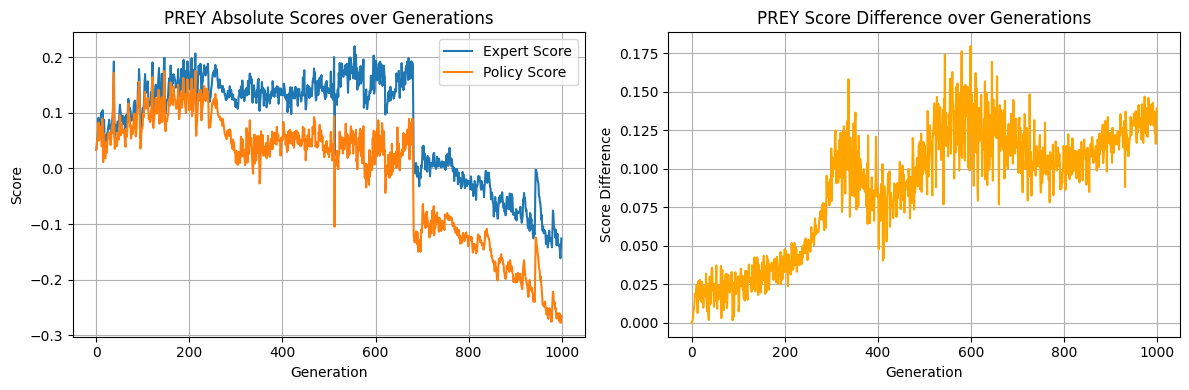

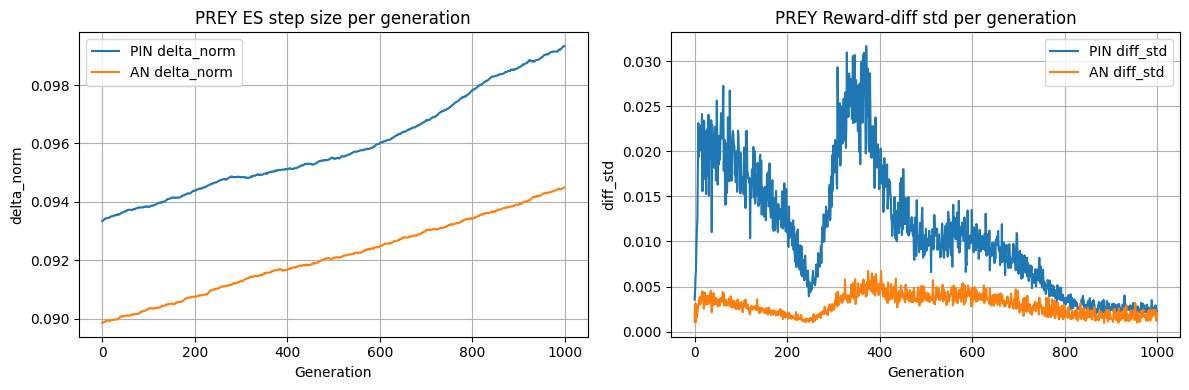

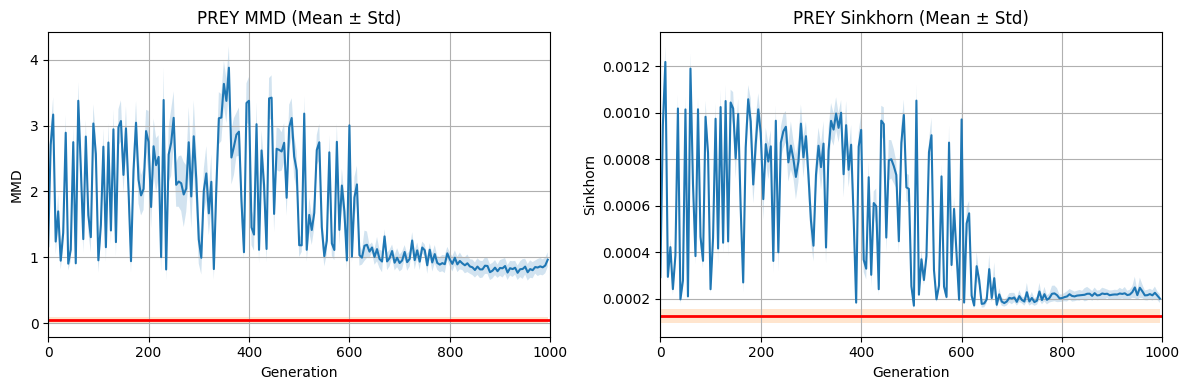

In [ ]:
%matplotlib inline
plot_train_metrics(disc_metrics_list, prey_dis_balance_factor, role="prey", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

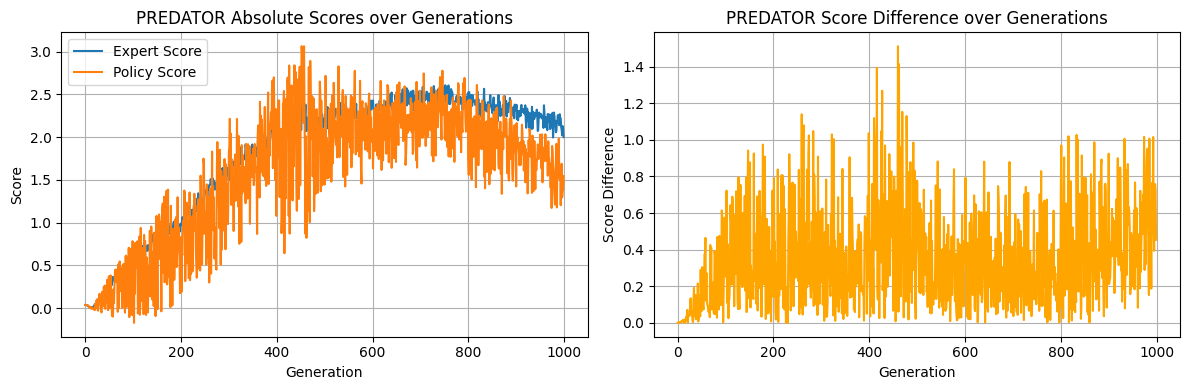

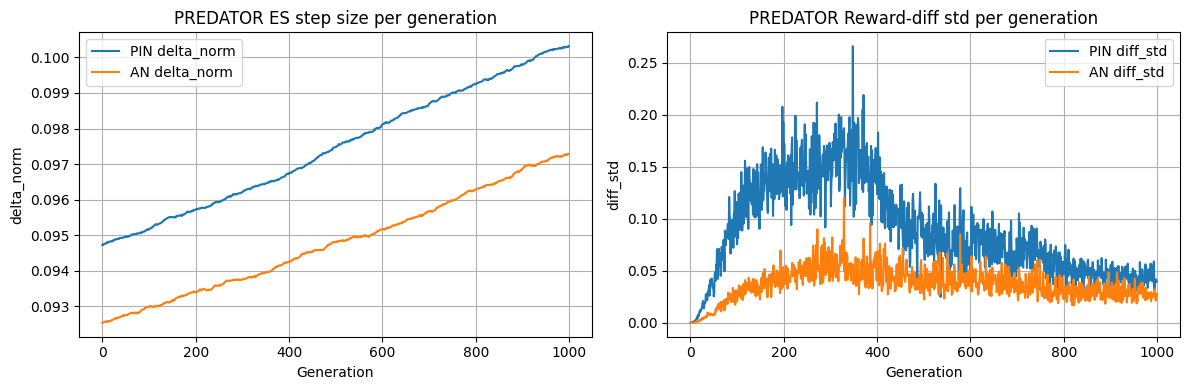

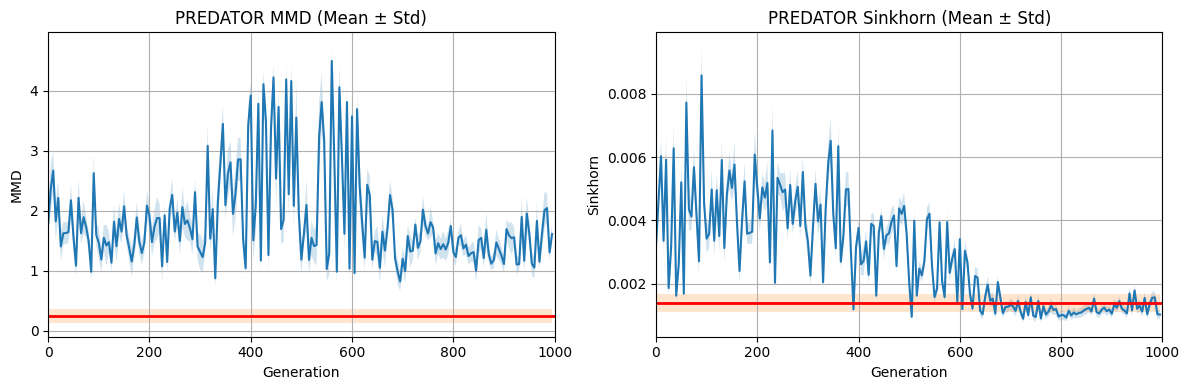

In [ ]:
%matplotlib inline
plot_train_metrics(disc_metrics_list, pred_dis_balance_factor, role="predator", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="predator", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="predator", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

In [ ]:
%matplotlib tk
gen_pred_tensor, gen_prey_tensor, gen_metrics = run_env_simulation(visualization='on', 
                                            prey_policy=prey_policy, pred_policy=pred_policy,
                                            n_prey=32, n_pred=1, 
                                            max_steps=300,
                                            pred_speed=pred_speed, prey_speed=prey_speed,
                                            area_width=width, area_height=height,
                                            max_turn = max_turn,
                                            step_size=step_size)